# Data Science - Binary Classification methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Loading Data

In [2]:
train = './data/training.csv'
test = './data/validation.csv'

df_train = pd.read_csv(train, sep=';', dtype='str')
df_test = pd.read_csv(test, sep=';', dtype='str')

In [3]:
# Add a new column: type and assign values = test/train, and concat both df, so we can perform EDA and transformations.
# We can split the df into training and test df when we get to building model phase.

df_train['type'] = 'train'
df_test['type'] = 'test'
df = pd.concat([df_train,df_test], axis=0)

# Data Preprocessing

In [4]:
# Finding numerical columns vs categorical columns
df.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel,type
0,a,"17,92","5,4e-05",u,"-0,840182024985552","0,522882590622095","1,75",f,t,1,t,g,80,5,8e+05,t,0,no.,train
1,b,"16,92","3,35e-05",y,"-2,15963506605476","0,774187133555115","0,29",f,f,0,f,s,200,0,2e+06,NaN,0,no.,train
2,b,"31,25","0,0001125",u,"1,75068668089807","0,76036270650308",0,f,t,1,f,g,96,19,960000,t,0,no.,train


In [5]:
df.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel,type
count,3858,3858,3900,3834,3900,3900,3900,3900,3900,3900,3900,3900,3797,3900,3797,1644,3900,3900,3900
unique,2,349,240,3,3900,3900,132,2,2,23,2,4,170,240,181,2,2,2,2
top,b,"23,25",0,u,"1,094673679","0,93951045",0,t,t,0,f,g,0,0,0,t,1,yes.,train
freq,2523,65,139,3204,1,1,280,3286,2335,1565,2024,3610,987,1525,987,1064,3524,3517,3700


## Segregating Numerical/Categorical Columns
- Numerical Columns: v2, v3, v5, v6, v7, v10, v13, v14, v15
- Categorical Columns: v1, v4, v8, v9, v11, v12, v16, v17

## Cleaning Numerical Columns: Fix the value formats
- Replace , with . and convert all the values into floating point

In [6]:
cols_numerical = ['v2', 'v3', 'v5', 'v6', 'v7', 'v10', 'v13', 'v14', 'v15']
cols_categorical = ['v1', 'v4', 'v8', 'v9', 'v11', 'v12', 'v16', 'v17']

for col in cols_numerical:
    df[col] = df[col].astype('str').str.replace(',','.').astype('float')

In [7]:
df[cols_numerical].describe()

,v2,v3,v5,v6,v7,v10,v13,v14,v15
count,3858.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3797.000000,3900.000000,3.797000e+03
mean,32.783053,0.000578,-0.071465,0.779205,3.367564,4.090000,164.625494,2165.322051,1.646255e+06
std,12.642751,0.000539,2.867708,0.142128,4.278889,6.651155,159.430670,8497.227982,1.594307e+06
min,13.750000,0.000000,-4.996939,-0.038309,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,22.920000,0.000146,-2.524033,0.688982,0.500000,0.000000,0.000000,0.000000,0.000000e+00
50%,28.670000,0.000425,-0.070306,0.785786,1.750000,1.000000,120.000000,100.000000,1.200000e+06
75%,40.330000,0.000954,2.394747,0.873926,4.750000,6.000000,280.000000,1000.000000,2.800000e+06
max,80.250000,0.002800,4.999274,1.215066,28.500000,67.000000,2000.000000,100000.000000,2.000000e+07


## Cleaning Numerical Columns: Handling NAs
- We can either remove the records with NAs, or fill with values
- I am going to fill the NA records with values that seems fit for the columns.
    - Value = 0, may be a bigger value for a few columns and may not makes sense in a few columns.
    - So, I am going to apply quantile(.10) as the min(value) may be an outlier/incorrect data.

In [8]:
df[df['v2'].isna()].head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel,type
28,a,NaN,0.00035,u,-1.566005,0.414830,3.0,t,f,0.0,t,g,300.0,0.0,3000000.0,NaN,0,no.,train
38,b,NaN,0.00050,y,0.002465,0.737592,8.5,t,f,0.0,f,g,0.0,0.0,0.0,f,0,no.,train
137,b,NaN,0.00105,u,-4.546401,0.807274,6.5,t,f,0.0,f,g,0.0,0.0,0.0,f,1,yes.,train


In [9]:
for col in cols_numerical:
    df[col] = df[col].fillna(df[col].quantile(.10))

In [10]:
df.iloc[[28]]

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel,type
28,a,20.17,0.00035,u,-1.566005,0.41483,3.0,t,f,0.0,t,g,300.0,0.0,3000000.0,NaN,0,no.,train


In [11]:
df[cols_numerical].describe()

,v2,v3,v5,v6,v7,v10,v13,v14,v15
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3.900000e+03
mean,32.647221,0.000578,-0.071465,0.779205,3.367564,4.090000,160.277692,2165.322051,1.602777e+06
std,12.641701,0.000539,2.867708,0.142128,4.278889,6.651155,159.510818,8497.227982,1.595108e+06
min,13.750000,0.000000,-4.996939,-0.038309,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,22.830000,0.000146,-2.524033,0.688982,0.500000,0.000000,0.000000,0.000000,0.000000e+00
50%,28.500000,0.000425,-0.070306,0.785786,1.750000,1.000000,120.000000,100.000000,1.200000e+06
75%,40.000000,0.000954,2.394747,0.873926,4.750000,6.000000,274.000000,1000.000000,2.740000e+06
max,80.250000,0.002800,4.999274,1.215066,28.500000,67.000000,2000.000000,100000.000000,2.000000e+07


## Cleaning categorical columns: Encoding

In [12]:
# Expand and encode all the categorical columns.
df = pd.get_dummies(df, columns=cols_categorical, dtype='int')

In [13]:
pd.set_option('display.max_columns', None)
df.head(3)

,v2,v3,v5,v6,v7,v10,v13,v14,v15,classLabel,type,v1_a,v1_b,v4_l,v4_u,v4_y,v8_f,v8_t,v9_f,v9_t,v11_f,v11_t,v12_g,v12_o,v12_p,v12_s,v16_f,v16_t,v17_0,v17_1
0,17.92,0.000054,-0.840182,0.522883,1.75,1.0,80.0,5.0,800000.0,no.,train,1,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,1,1,0
1,16.92,0.000034,-2.159635,0.774187,0.29,0.0,200.0,0.0,2000000.0,no.,train,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0
2,31.25,0.000112,1.750687,0.760363,0.00,1.0,96.0,19.0,960000.0,no.,train,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1,1,0


# Data Exploration

## Checking for outliers/extreme values in numerical columns

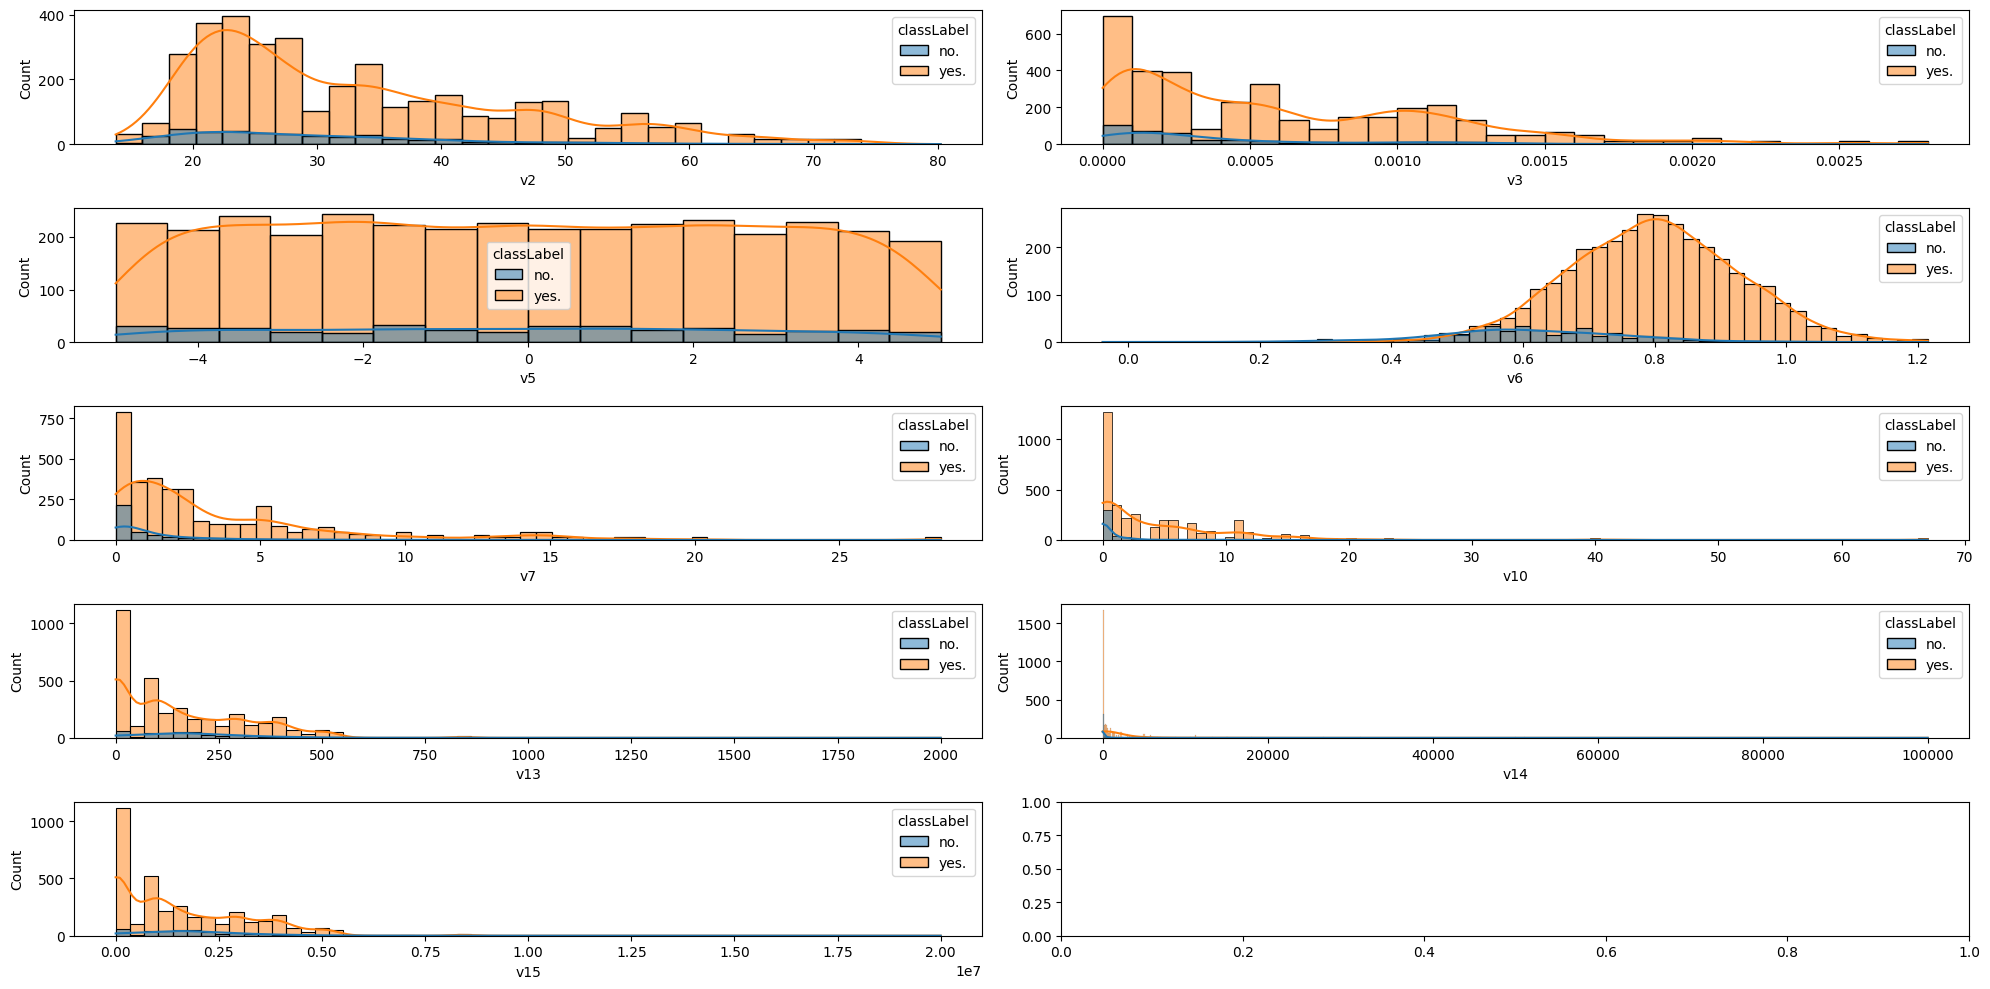

In [14]:
fig, ax = plt.subplots(nrows=(len(cols_numerical)//2)+1, ncols=2, figsize=(20,10))
ax = ax.flatten()
for idx, col in enumerate(cols_numerical):
    sns.histplot(data=df, x=col, hue='classLabel', kde=True, ax=ax[idx])
plt.tight_layout()
plt.show()

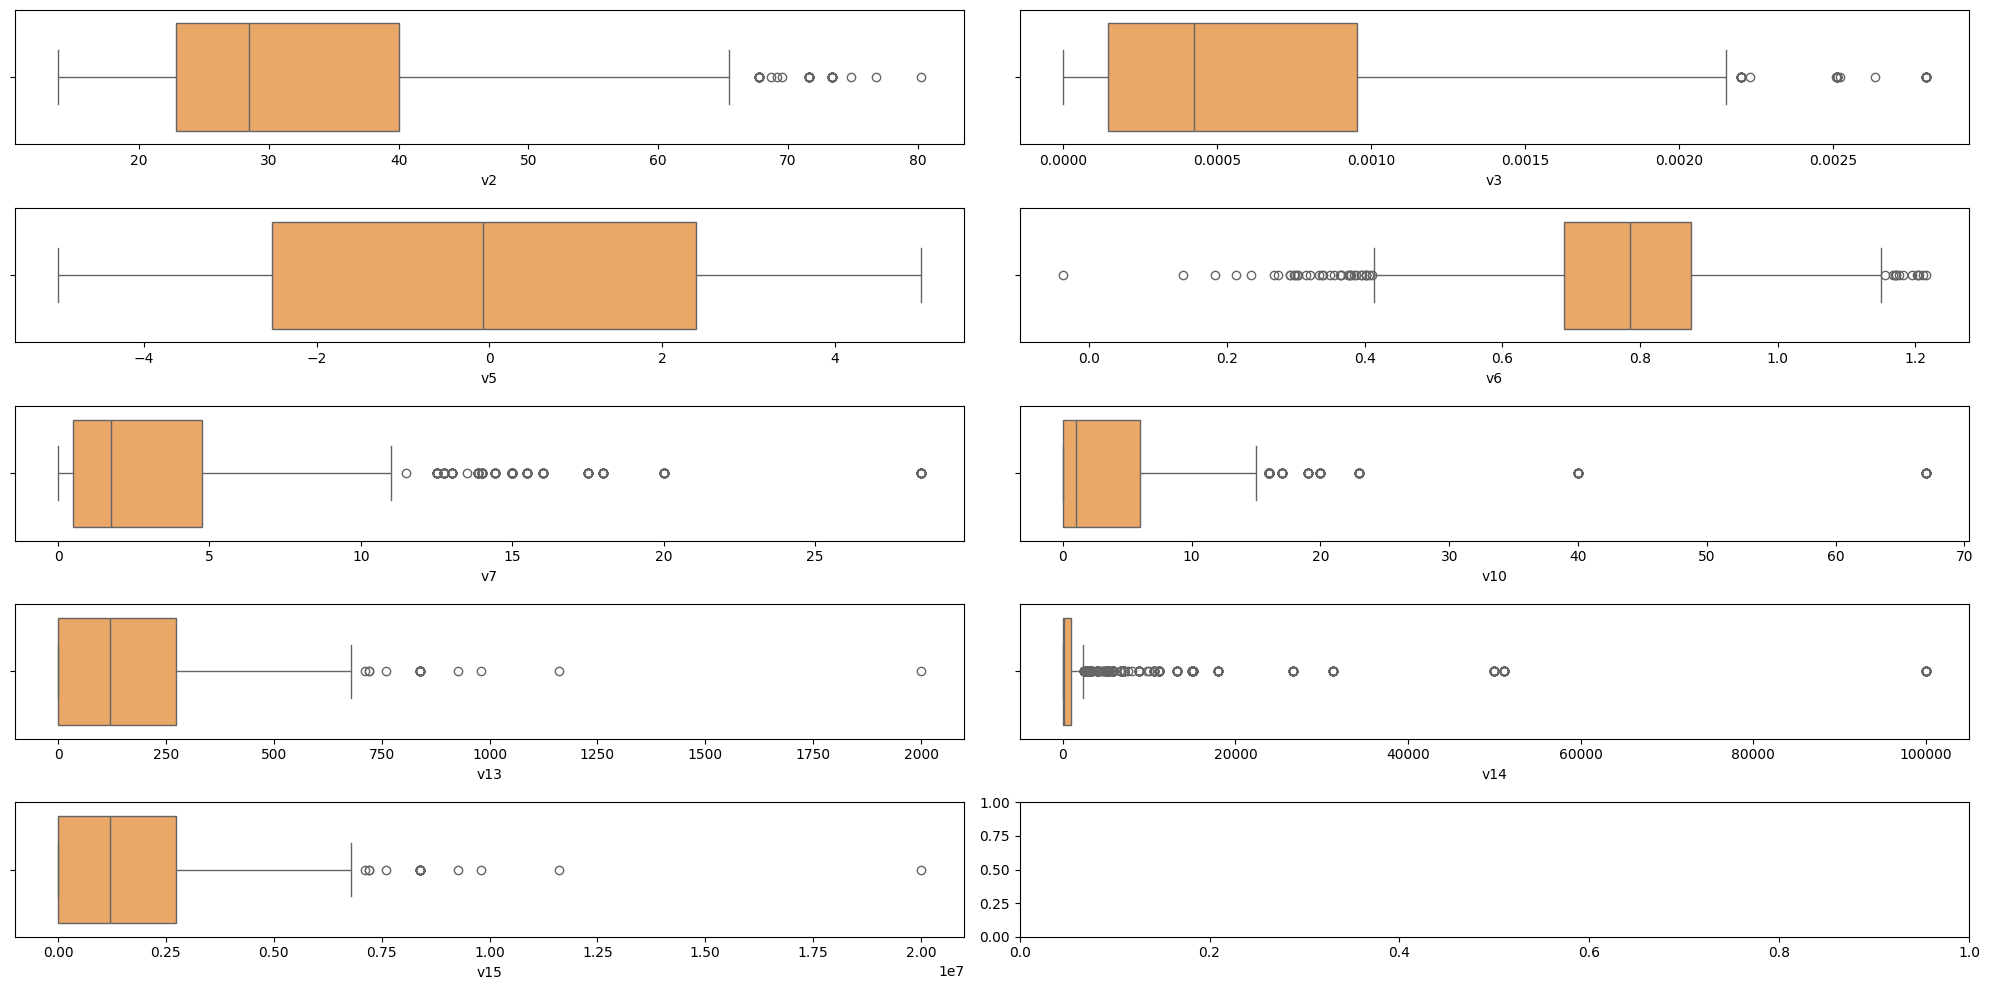

In [15]:
fig, ax = plt.subplots(nrows=(len(cols_numerical)//2)+1, ncols=2, figsize=(20,10))
ax = ax.flatten()
for idx, col in enumerate(cols_numerical):
    sns.boxplot(data=df, x=col, color='#FFA652' ,ax=ax[idx])
plt.tight_layout()
plt.show()

## Fixing outliers
- Remove entire rows
- Capping the values by 99th percentile up and down

In [16]:
# Capping the values to 99th percentile up and down.
df_beforeCapping = df

for col in cols_numerical:
    upperLimit = df[col].quantile(.99)
    lowerLimit = df[col].quantile(.01)
    df[col] = df[col].clip(upper=upperLimit, lower=lowerLimit)

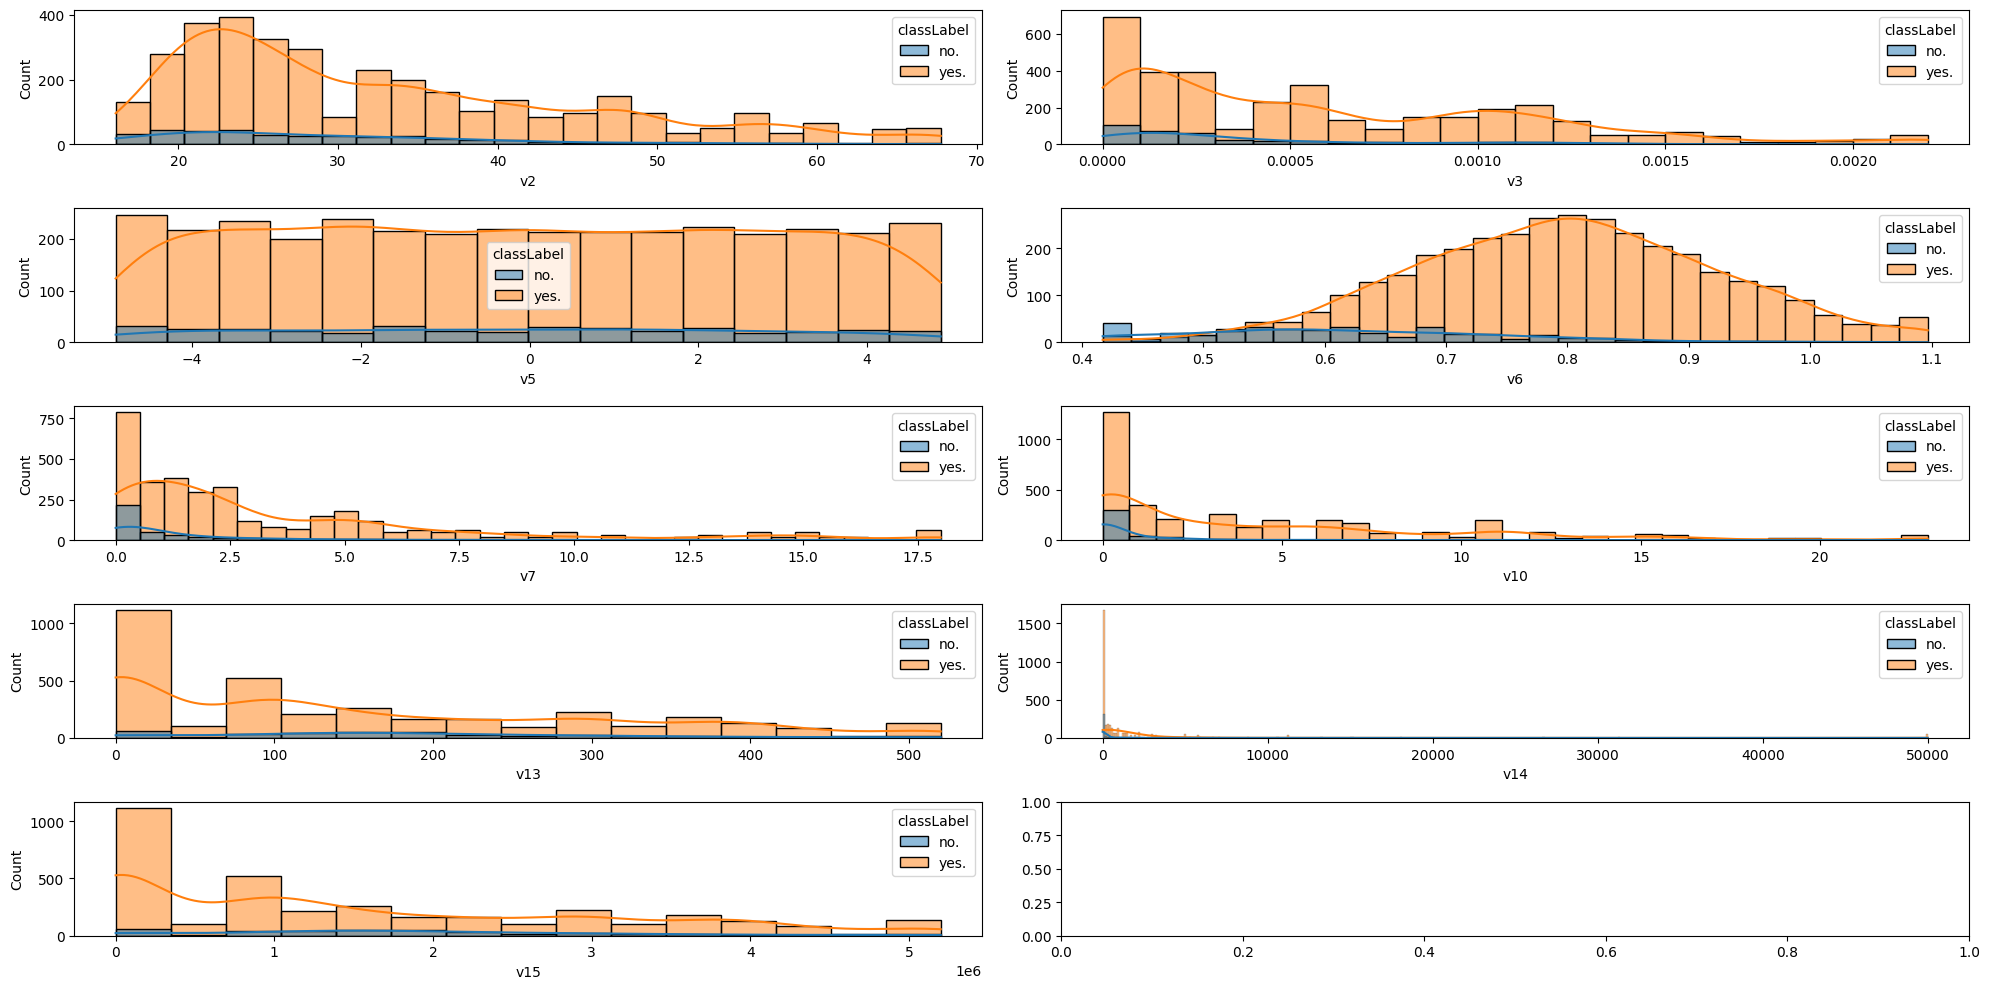

In [17]:
fig, ax = plt.subplots(nrows=(len(cols_numerical)//2)+1, ncols=2, figsize=(20,10))
ax = ax.flatten()
for idx, col in enumerate(cols_numerical):
    sns.histplot(data=df, x=col, hue='classLabel', kde=True, ax=ax[idx])
plt.tight_layout()
plt.show()

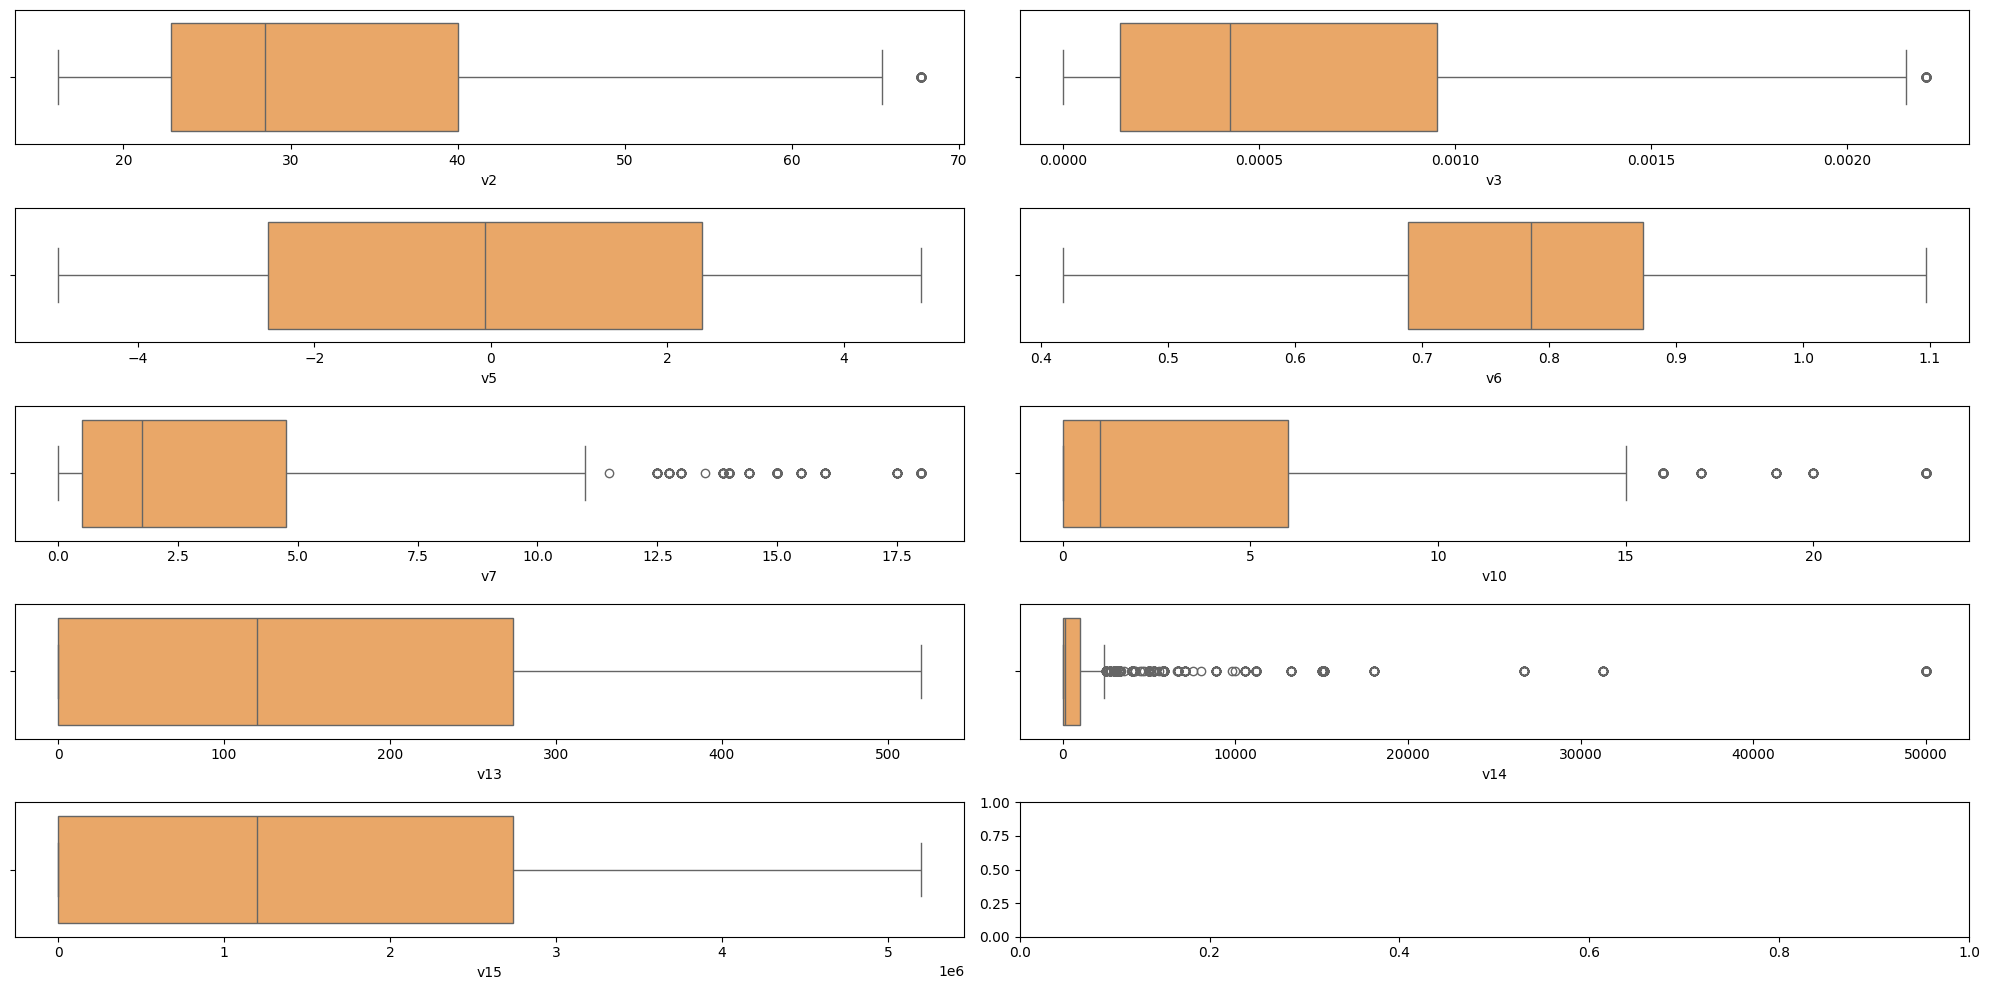

In [18]:
fig, ax = plt.subplots(nrows=(len(cols_numerical)//2)+1, ncols=2, figsize=(20,10))
ax = ax.flatten()
for idx, col in enumerate(cols_numerical):
    sns.boxplot(data=df, x=col, color='#FFA652', ax=ax[idx])
plt.tight_layout()
plt.show()

<Axes: xlabel='v14', ylabel='Count'>

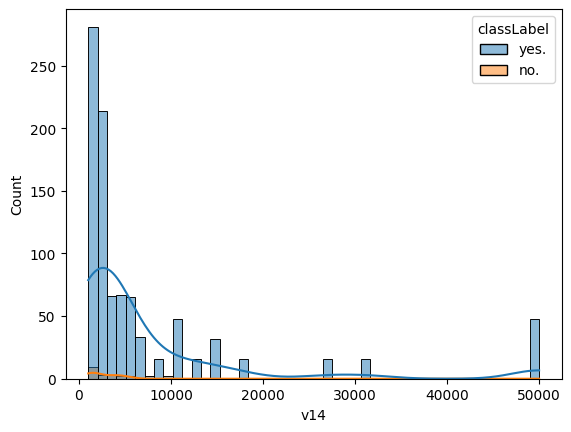

In [19]:
# Outliers are removed in all the columns except in v14
# Column: v14 has values that starts from 0 and looks like increasing exponentially. Plus there is a quite a decent amount of distribution observed for very large values

sns.histplot(data=df[df['v14'] > 1000], x='v14', kde=True, hue='classLabel')

<Axes: >

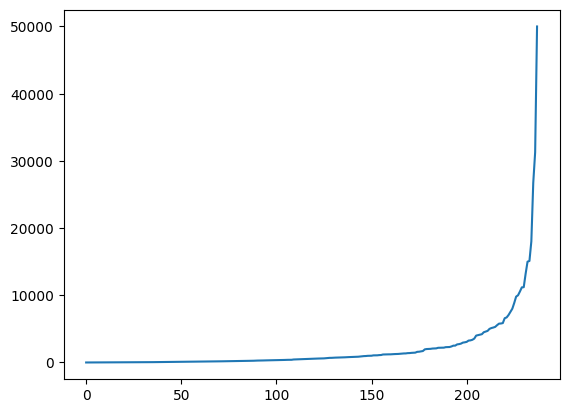

In [20]:
sns.lineplot(data=df['v14'].sort_values().unique())

C:\Users\srth9001\AppData\Local\Temp\1\ipykernel_5600\2683856267.py:1: RuntimeWarning: divide by zero encountered in log
  sns.lineplot(data=np.log(df['v14'].sort_values().unique()))


<Axes: >

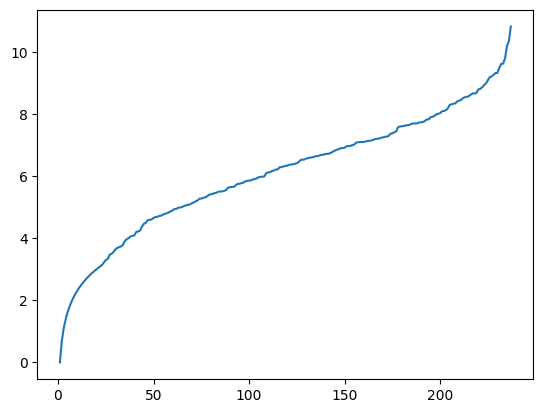

In [21]:
sns.lineplot(data=np.log(df['v14'].sort_values().unique()))

In [22]:
# Transform this column to log(values) to bring down the exponential values to linear
df['v14_log'] = np.log(df['v14']+ 1)
df = df.drop(columns='v14')

<Axes: xlabel='v14_log', ylabel='Count'>

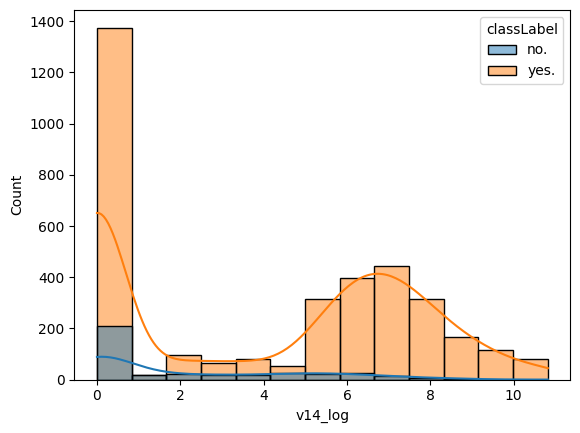

In [23]:
sns.histplot(data=df, x='v14_log', kde=True, hue='classLabel')

In [24]:
df.head(3)

,v2,v3,v5,v6,v7,v10,v13,v15,classLabel,type,v1_a,v1_b,v4_l,v4_u,v4_y,v8_f,v8_t,v9_f,v9_t,v11_f,v11_t,v12_g,v12_o,v12_p,v12_s,v16_f,v16_t,v17_0,v17_1,v14_log
0,17.92,0.000054,-0.840182,0.522883,1.75,1.0,80.0,800000.0,no.,train,1,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,1,1,0,1.791759
1,16.92,0.000034,-2.159635,0.774187,0.29,0.0,200.0,2000000.0,no.,train,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0.000000
2,31.25,0.000112,1.750687,0.760363,0.00,1.0,96.0,960000.0,no.,train,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1,1,0,2.995732


# Feature Selection

In [25]:
# Convert class Label column into 0/1
df['classLabel'] = (df['classLabel'] == 'yes.').astype(int)
df.head(3)

,v2,v3,v5,v6,v7,v10,v13,v15,classLabel,type,v1_a,v1_b,v4_l,v4_u,v4_y,v8_f,v8_t,v9_f,v9_t,v11_f,v11_t,v12_g,v12_o,v12_p,v12_s,v16_f,v16_t,v17_0,v17_1,v14_log
0,17.92,0.000054,-0.840182,0.522883,1.75,1.0,80.0,800000.0,0,train,1,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,1,1,0,1.791759
1,16.92,0.000034,-2.159635,0.774187,0.29,0.0,200.0,2000000.0,0,train,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0.000000
2,31.25,0.000112,1.750687,0.760363,0.00,1.0,96.0,960000.0,0,train,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1,1,0,2.995732


## Analyzing correlation matrix to select/drop columns for Feature

In [26]:
corr_matrix = df.drop(columns='type').corr()

<Axes: ylabel='classLabel'>

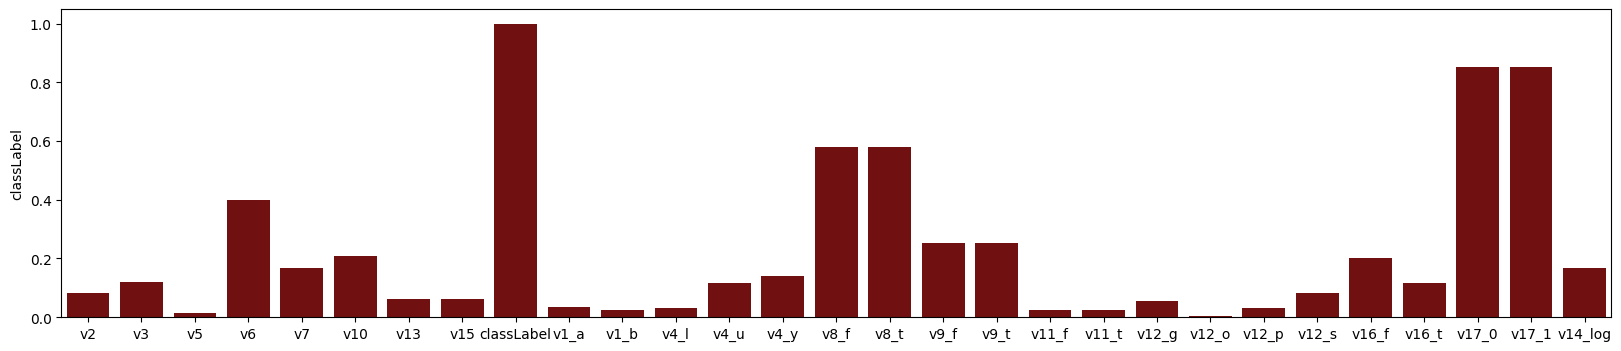

In [27]:
plt.figure(figsize=(20,4))
sns.barplot(data=corr_matrix['classLabel'].abs(), color='#800000')

## Observations
- Columns v17_0 and v17_1 has coefficient > 0.8. It'd be ideal if we remove these columns as this may leak the classification data.
- Columns: v8_f and v8_t, v9_f and v9_t, v11_f and v11_t has the same coeff value (pairs). We can keep one of these columns

In [28]:
df = df.drop(columns=['v17_0','v17_1','v8_f', 'v9_f', 'v11_f'])

In [29]:
corr_matrix_update_1 = df.drop(columns='type').corr()

In [30]:
corr_matrix_update_1.columns

Index(['v2', 'v3', 'v5', 'v6', 'v7', 'v10', 'v13', 'v15', 'classLabel', 'v1_a',
       'v1_b', 'v4_l', 'v4_u', 'v4_y', 'v8_t', 'v9_t', 'v11_t', 'v12_g',
       'v12_o', 'v12_p', 'v12_s', 'v16_f', 'v16_t', 'v14_log'],
      dtype='object')

<Axes: ylabel='classLabel'>

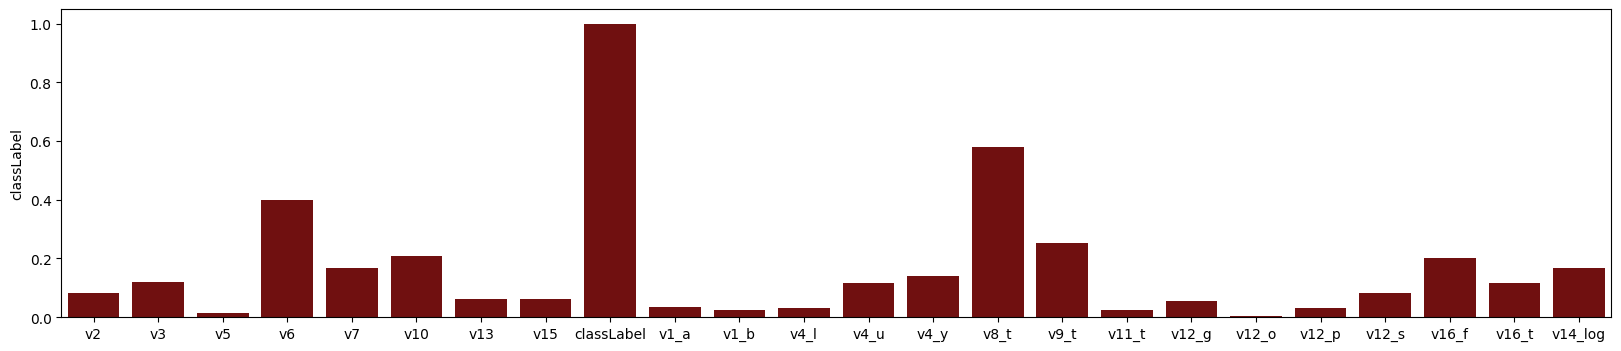

In [31]:
plt.figure(figsize=(20,4))
sns.barplot(data=corr_matrix_update_1['classLabel'].abs(), color='#800000')

## Splitting the test and train datasets

In [32]:
# X = Features, y = Class

X_train = df[df['type'] == 'train'].drop(columns=['type','classLabel'])
y_train = df[df['type'] == 'train']['classLabel']

X_test = df[df['type'] == 'test'].drop(columns=['type','classLabel'])
y_test = df[df['type'] == 'test']['classLabel']

# Binary Classification - Models

## kNN Classification

In [33]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [34]:
scores = {'classifier' : [], 'accuracy' : []}

In [35]:
knn.score(X_test, y_test)

0.575

### Observation
- We have accuracy = 0.57
- Perhaps, we can try removing feautures that are not correlated with the classification (< 0.1) and fit the model

### Removing feautures with correlation coefficient < 0.1 from test and training features

In [36]:
cols_to_drop = corr_matrix_update_1[corr_matrix_update_1['classLabel'].abs() < 0.1]['classLabel'].index.to_list()
X_train_knn = X_train.drop(columns=cols_to_drop)
X_test_knn = X_test.drop(columns=cols_to_drop)

knn.fit(X_train_knn, y_train)
y_pred = knn.predict(X_test_knn)

In [37]:
knn_score = knn.score(X_test_knn, y_test)

In [38]:
scores['classifier'].append('knn')
scores['accuracy'].append(knn_score)

### Observation - Accuracy is improved from 0.57 to 0.72, after removing features with less corr coeff with the classification.

## Logistic Regression

In [39]:
lr = LogisticRegression(max_iter=2000, )
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [40]:
lr_score = lr.score(X_test, y_test)

In [41]:
scores['classifier'].append('Logistic Regression')
scores['accuracy'].append(lr_score)

## Naive Bayes Classification

In [42]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [43]:
nb_score = nb.score(X_test, y_test)
nb_score

0.465

### Observation - Trying to improve accuracy by considering only the numerical columns

In [44]:
cols_numerical.remove('v14')
cols_numerical.append('v14_log')
cols_numerical

['v2', 'v3', 'v5', 'v6', 'v7', 'v10', 'v13', 'v15', 'v14_log']

In [45]:
X_train_numerical = X_train[cols_numerical]
X_test_numerical = X_test[cols_numerical]

In [46]:
nb.fit(X_train_numerical, y_train)
nb.score(X_test_numerical, y_test)

0.465

### Observation - Considering the numerical columns that follows the gaussian curve of distribution: v2, v6, v14

In [47]:
cols = ['v2','v6','v14_log']
X_train_numerical = X_train[cols]
X_test_numerical = X_test[cols]
nb.fit(X_train_numerical, y_train)
nb_score = nb.score(X_test_numerical, y_test)

### Accuracy is improved when we used the feautures/columns where the values are distributed uniformly

In [48]:
scores['classifier'].append('Naive Bayes (Gaussian)')
scores['accuracy'].append(nb_score)

In [49]:
pd.DataFrame(scores)

,classifier,accuracy
0,knn,0.710
1,Logistic Regression,0.610
2,Naive Bayes (Gaussian),0.605
